In [ ]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from keras import models
from keras import layers
from tensorflow.keras.applications.xception import preprocess_input

#!pip install tensorflow-addons
#import tensorflow_addons as tfa

#!pip install visualkeras
#import visualkeras


tfk = tf.keras
tfkl = tf.keras.layers

     |████████████████████████████████| 1.1 MB 7.7 MB/s 
     |████████████████████████████████| 795 kB 7.8 MB/s 


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Dataset folders 
dataset_dir = '../input/dataset21/dataset1/training_set1'
validation_dir = '../input/dataset21/dataset1/validation_set1'

input_shape = (256, 256, 3)
epochs = 50

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
    if i < len(labels):
        class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
"MODELLO"

# Download and plot the model
supernet = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None)

supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
inputs1= tf.keras.layers.GaussianNoise(0.1)(inputs)

x = tfkl.Resizing(256, 256, interpolation="bicubic")(inputs1)
x1 = supernet(x)

batchNorm5 = tfkl.BatchNormalization(axis=-1)(x1)
glob_av_pooling = tfkl.GlobalAveragePooling2D(name='GloablPooling')(batchNorm5)     #(conv3)
glob_pooling1 = tfkl.Dropout(0.3,seed = seed, name='GlobalPoolingDropout')(glob_av_pooling)
classifier_layer1 = tfkl.Dense(units=1024, name='Classifier1', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(glob_pooling1)
classifier_layer2 = tfkl.Dropout(0.3, seed=seed)(classifier_layer1)
classifier_layer3 = tfkl.Dense(units=512, name='Classifier3', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(classifier_layer2)
classifier_layer4 = tfkl.Dropout(0.3, seed=seed)(classifier_layer3)
outputs = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer4)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 256, 256, 3)      0         
 oise)                                                           
                                                                 
 resizing_1 (Resizing)       (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 2048)       8192      
 hNormalization)                                                 
                                                                 
 GloablPooling (GlobalAverag  (None, 2048)             0     

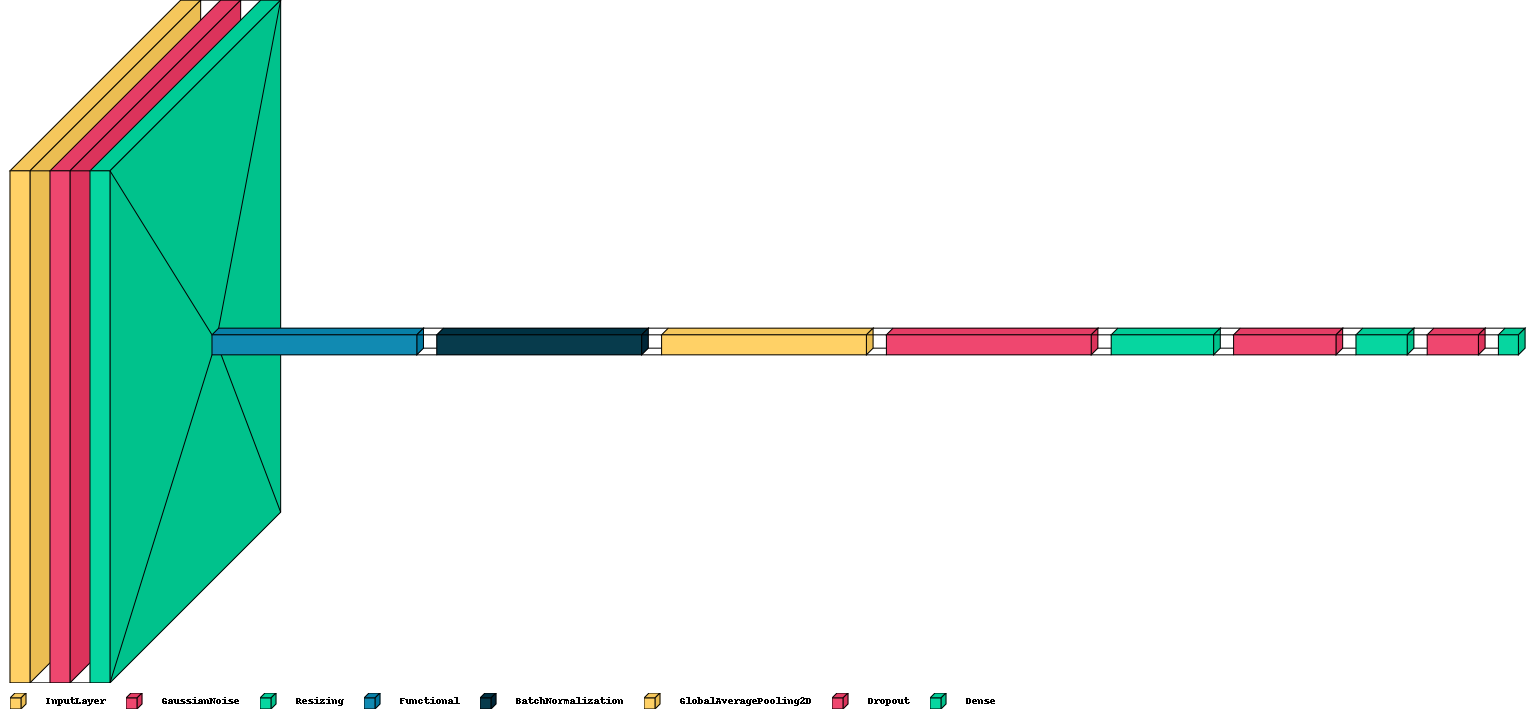

In [ ]:
# Connect input and output through the Model class

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
model.summary()

#visualizza il modello
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=2)

In [ ]:
"Changes to Xception"
# Set all layers to True
model.get_layer('xception').trainable = True
for i, layer in enumerate(model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)

print('\n')
# Freeze first N layers
for i, layer in enumerate(model.get_layer('xception').layers[:113]):
    layer.trainable=False
for i, layer in enumerate(model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)
model.summary()

0 input_3 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_4 True
13 block2_pool True
14 batch_normalization_5 True
15 add_12 True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_5 True
23 block3_pool True
24 batch_normalization_6 True
25 add_13 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_6 True
33 block4_pool True
34 batch_normalization_7 True
35 add_14 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 b

In [ ]:
#AUGMENTATION on TRAINING

aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                         height_shift_range=50,
                         width_shift_range=50,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect',
                         preprocessing_function=preprocess_input)
                        

aug_train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               classes=None, 
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
                                               

#VALIDATION without augmentation 

val_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method

val_gen = val_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               classes=None, 
                                               batch_size=32,
                                               shuffle=False,
                                               seed=seed)
                                              
                                               


In [ ]:
#BALANCE THE DATASET
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(aug_train_gen.classes),
                                        y = aug_train_gen.classes                                                    
                                    )
class_weights = dict(zip(np.unique(aug_train_gen.classes), class_weights))

print(class_weights)

In [ ]:
from datetime import datetime
def create_callbacks():
    callbacks = []

    exps_dir = os.path.join('trained')
    if not os.path.exists(exps_dir):
              os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, 'ToyNotebook' + '_' + str(now))
    if not os.path.exists(exp_dir):
                  os.makedirs(exp_dir)

          # Model checkpoint
          # ----------------
    ckpt_dir = os.path.join(exp_dir, 'trained/checkpoint.ckpt')
    if not os.path.exists(ckpt_dir):
                  os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                             save_weights_only=False,
                                                             save_best_only=True)
    callbacks.append(ckpt_callback)

          # Early Stopping
          # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

    
    
    return callbacks




In [ ]:
tf.get_logger().setLevel('WARNING') 

# Create folders and callbacks and fit

callbacks = create_callbacks()

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    steps_per_epoch = 15963/32,
    validation_data = val_gen,
    class_weight = class_weights,
    callbacks = callbacks)

In [ ]:
#Save best epoch model
model.save("trained/Model13.1")

In [ ]:
#plot

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(32, 16))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

y_pred = np.argmax(model.predict_generator(val_gen, steps=len(val_gen)), axis=1) 
y_true = np.concatenate([np.argmax(val_gen[i][1], axis=1) for i in range(len(val_gen))])

# Compute the classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T,
            xticklabels=labels,
            yticklabels=labels,
            annot=True, 
            fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()